In [11]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import statistics as stat

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show, ColumnDataSource

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')
output_notebook()

Loading BokehJS ...

In [12]:
def getTimeStamp(date):
    return int(pd.read_sql(sql='select strftime("%s",?)', con=engine, params=[date]).loc[0][0])

In [13]:
def getNAV(names,start,end):
    date = pd.read_sql(sql='select distinct date from price where date between ? and ? order by date asc',
                       con=engine,index_col='date', params=[start,end]).index
    NAV = np.zeros((len(names),len(date)))
    for j in range (len(names)):
        temp = pd.read_sql(sql='select * from price where id = ? and date between ? and ? order by date asc',
                   con=engine,index_col='date', params=[names[j],start,end])
        NAV[j][0] = temp.iloc[0]['NAV']
        for i,day in enumerate(date[1:]):
            try:
                NAV[j][i+1] = temp.loc[day]['NAV']
            except:
                NAV[j][i+1] = NAV[j][i]
    return NAV

In [14]:
def poolDecide(year):
    start = getTimeStamp(year + '-12-01')
    end = getTimeStamp(year + '-12-31')
    names = pd.read_sql(sql='select distinct id from price where date between ? and ?',
                        con=engine, params=[start,end])
    names = names['id'].sample(n=300).values
    return names

In [15]:
year = input("請輸入欲回測年：")
past_year = str(int(year)-1)
start = getTimeStamp(year+'-01-01')
end = getTimeStamp(year+'-12-31')

請輸入欲回測年：2010


# 0. 抓出0050各項數據

## 一. 淨值

In [16]:
NAV_0050 = getNAV(['0050 元大台灣50'], start, end)[0]

In [17]:
NAV_0050

array([56.67, 56.92, 57.9 , 57.36, 57.58, 57.82, 57.59, 56.66, 57.42,
       57.91, 57.55, 56.88, 56.61, 56.09, 54.62, 54.37, 52.96, 52.79,
       53.5 , 53.18, 52.16, 51.85, 52.8 , 52.6 , 50.61, 51.03, 50.72,
       51.48, 51.92, 52.77, 52.97, 52.32, 51.56, 51.62, 52.56, 52.71,
       52.84, 52.34, 53.07, 53.86, 53.88, 53.92, 53.7 , 53.63, 52.81,
       53.19, 54.25, 54.32, 54.32, 53.62, 53.49, 53.53, 53.7 , 54.02,
       54.37, 54.5 , 54.1 , 54.75, 54.79, 55.32, 55.55, 55.01, 55.27,
       55.46, 54.84, 55.26, 55.7 , 55.16, 53.75, 54.01, 54.55, 54.47,
       54.64, 55.92, 55.93, 55.37, 54.98, 54.89, 54.57, 54.5 , 52.92,
       52.13, 52.  , 52.53, 52.1 , 52.03, 53.25, 53.11, 51.94, 51.85,
       51.46, 50.7 , 49.79, 50.3 , 48.9 , 49.43, 49.6 , 49.9 , 50.37,
       49.73, 48.99, 50.21, 50.04, 48.65, 48.4 , 48.08, 48.84, 49.68,
       50.32, 50.78, 51.21, 51.07, 51.99, 51.62, 51.31, 51.32, 50.64,
       50.76, 50.29, 49.57, 48.91, 49.44, 50.38, 51.38, 51.35, 52.12,
       52.52, 52.45,

## 二.配息

In [18]:
interest_0050 = (pd.read_sql(sql='select interest from interest where date between ? and ? and id = "0050 元大台灣50"'
                                ,con = engine, params=[start,end])['interest'].sum())

In [19]:
interest_0050

2.2

## 三. 漲跌幅

In [20]:
rate_0050 = []
rate_0050.append(0)
for i in range (len(NAV_0050)-1):
    rate_0050.append((NAV_0050[i+1] - NAV_0050[i]) / NAV_0050[i])

In [21]:
rate_0050

[0,
 0.0044115052055761425,
 0.01721714687280388,
 -0.009326424870466306,
 0.0038354253835425184,
 0.004168113928447412,
 -0.003977862331373173,
 -0.01614863691613139,
 0.013413342746205528,
 0.008533611981887755,
 -0.006216542911414254,
 -0.011642050390964286,
 -0.0047468354430380295,
 -0.009185656244479704,
 -0.026207880192547797,
 -0.0045770779934090075,
 -0.025933419164980626,
 -0.0032099697885196697,
 0.01344951695396857,
 -0.005981308411214958,
 -0.019180142910868808,
 -0.005943251533742239,
 0.018322082931533187,
 -0.0037878787878787073,
 -0.0378326996197719,
 0.008298755186722025,
 -0.006074857926709823,
 0.0149842271293375,
 0.008547008547008642,
 0.016371340523882925,
 0.003790032215273749,
 -0.012271096847272013,
 -0.014525993883792011,
 0.0011636927851046387,
 0.018209996125532833,
 0.0028538812785387857,
 0.0024663251754885704,
 -0.009462528387585161,
 0.013947267863966313,
 0.014885999623139233,
 0.00037133308577800086,
 0.0007423904974016174,
 -0.0040801186943619965,
 -0

## 四. 收益率

In [22]:
profit_0050 = []
for i in range(len(NAV_0050)):
    profit_0050.append((NAV_0050[i] - NAV_0050[0]) / NAV_0050[0] * 100)
profit_0050[-1] += interest_0050

In [261]:
profit_0050

[0.4411505205576143,
 2.6116110817010707,
 3.3880359978824677,
 2.823363331568721,
 3.6350802893947325,
 3.652726310217046,
 1.6057878948297097,
 1.3058055408505291,
 3.5115581436386005,
 3.7409564143285516,
 1.9234162696311914,
 0.2646903123345661,
 -1.1293453326274934,
 -4.640903476266106,
 -7.6760190577025025,
 -10.605258514205055,
 -13.393329804129175,
 -12.44044467972473,
 -11.75224986765485,
 -14.116816657843668,
 -16.463737427210173,
 -15.334392094582679,
 -14.010940532909839,
 -17.875419092994534,
 -20.64584436209635,
 -20.451738133051002,
 -19.657667196047306,
 -17.54014469737075,
 -15.26380801129345,
 -13.410975824951477,
 -14.205046761955188,
 -16.693135697900125,
 -17.92835715546145,
 -16.16375507323099,
 -14.240338803599787,
 -13.74625022057526,
 -14.399152991000523,
 -13.993294512087523,
 -11.311099347097235,
 -9.88177166049056,
 -9.77589553555673,
 -10.093523910358211,
 -10.605258514205042,
 -12.175754367390152,
 -12.95217928357156,
 -10.411152285159705,
 -8.417151932239

# 1. 決定基金池

In [24]:
start = getTimeStamp(past_year + '-12-01')
end = getTimeStamp(past_year + '-12-31')
names = pd.read_sql(sql='select distinct id from price where date between ? and ?',
                        con=engine, params=[start,end])
names = names['id'].sample(n=300).values

In [25]:
names

array(['0052 富邦科技', 'FLZ49 富蘭坦全新固收B', 'ALZ60 聯博全球高收債AT', 'T3703Y 國泰中小成長',
       'PAZC3 法百新興債I$', 'PYZD0 施羅新興亞A1aEU', 'T0906Y 統一中小',
       'FLZ80 富蘭坦亞債A$mdis', 'FLZ30 富蘭坦新興國固收', 'SBZ56 瑞銀策略股票美元',
       'PLZ15 霸菱熟&新高債A$q', 'PYZF0 施羅德能源A1aEU', 'SPZ23 利安新馬SGD',
       'T0920Y 統一全球債券組合', 'FLZ94 富蘭坦公司債$Aa', 'T1708Y 德信萬保貨幣市場',
       'SPZ26 利安新加均衡SGD', 'GSF01 天達美國股票Ci', 'EUZ12 歐義新興市場債R2',
       'MFZE4 MFS全資配B1-USD', 'FHA06 CG全球股B$', 'AIZ02 柏瑞歐小型公司 Y',
       'FHA17 CG全球債T', 'FLZC1 富蘭坦精選$B.d', 'AIZ14 柏瑞亞洲ex日 Y',
       'MFZE8 MFS全資配C1-USD', 'EDM05 EDM 歐洲新力Aeur', 'JAZ85 駿利策略Alpha I$',
       'T1802Y 聯博大利', 'INZ21 NN 拉美X$', 'T1124Y 摩根絕對日本', 'AIZ58 柏環策略Aa$',
       'FTZB6 富全球不動產-USD', 'CPA04 瀚亞全球價值A', 'T3608Y 安聯亞洲動態',
       'PIZ43 鋒裕策收益AXD', 'ALZY0 聯博新市債AT.e', 'JAZ45 駿利靈活Be.i',
       'SBZ63 瑞銀美元高收債$', 'CPA03 瀚亞泛歐股票A', 'PAZ60 法百澳股C.AUD',
       'ALZY4 聯博新市債B2.e', 'CTY57 西資高收債A(G)$A', 'T4732Y 台新亞美短債',
       'SGF48 先機亞太股Ca$', '01004T 土銀富邦R2', 'T4504Y 富蘭克林華美新世',
       'FTZ59 富達歐元藍籌基金', 'ALZZ1

# 抓出淨值

In [26]:
NAV = getNAV(names, start, end)

In [27]:
NAV

array([[33.9   , 33.97  , 34.    , ..., 35.73  , 36.07  , 36.39  ],
       [16.97  , 17.    , 17.02  , ..., 17.04  , 17.05  , 17.05  ],
       [ 4.2   ,  4.21  ,  4.21  , ...,  4.3   ,  4.31  ,  4.28  ],
       ...,
       [14.23  , 14.25  , 14.21  , ..., 14.09  , 14.1   , 14.05  ],
       [ 7.172 ,  7.2318,  7.2534, ...,  7.1036,  7.0926,  7.1268],
       [ 9.6   ,  9.65  ,  9.59  , ...,  9.85  ,  9.85  ,  9.77  ]])

# 2.抓出Features

## 一. 抓出漲跌幅

In [28]:
length = len(NAV[0])-1
rate = np.zeros((len(names),length))
for j in range (len(names)):
    for i in range (length):
        rate[j][i] = (NAV[j][i+1] - NAV[j][i]) / NAV[j][i]

In [29]:
rate

array([[ 0.0020649 ,  0.00088313, -0.00588235, ..., -0.0002798 ,
         0.00951581,  0.00887164],
       [ 0.00176783,  0.00117647, -0.00235018, ...,  0.        ,
         0.00058685,  0.        ],
       [ 0.00238095,  0.        ,  0.0023753 , ...,  0.002331  ,
         0.00232558, -0.00696056],
       ...,
       [ 0.00140548, -0.00280702,  0.00211119, ..., -0.00141743,
         0.00070972, -0.0035461 ],
       [ 0.00833798,  0.00298681,  0.00016544, ...,  0.00180516,
        -0.00154851,  0.00482193],
       [ 0.00520833, -0.00621762,  0.00208551, ...,  0.        ,
         0.        , -0.00812183]])

## 二. 刪除協方差為零之基金

In [30]:
temp = []
for i,j in enumerate(rate):
    if np.cov(j) == 0:
        temp.append(i)

rate = np.delete(rate,temp,0)
names = np.delete(names,temp,0)
NAV = np.delete(NAV,temp,0)

## 三. 計算相關係數

In [31]:
similarity = np.zeros((len(rate),len(rate)))
for i in range(len(rate)):
    for j in range(len(rate)):
        corr = np.corrcoef(rate[i], rate[j])[0][-1]
        similarity[i][j] = 1-(corr*0.5+0.5)
for i in range(len(rate)):
    similarity[i][i] = 0

In [32]:
similarity

array([[0.        , 0.45887401, 0.65741669, ..., 0.43878304, 0.45762434,
        0.58605173],
       [0.45887401, 0.        , 0.32937818, ..., 0.1849337 , 0.31417174,
        0.20697524],
       [0.65741669, 0.32937818, 0.        , ..., 0.26704184, 0.47902706,
        0.21617374],
       ...,
       [0.43878304, 0.1849337 , 0.26704184, ..., 0.        , 0.38942725,
        0.21069433],
       [0.45762434, 0.31417174, 0.47902706, ..., 0.38942725, 0.        ,
        0.49035476],
       [0.58605173, 0.20697524, 0.21617374, ..., 0.21069433, 0.49035476,
        0.        ]])

# 4.進行分群

In [33]:
clustering = AgglomerativeClustering(n_clusters=4).fit(similarity)

/Users/Angu/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [35]:
clustering.labels_

array([0, 2, 3, 0, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 1, 0, 0, 3, 0, 2, 2, 2,
       1, 0, 0, 2, 2, 3, 0, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1,
       0, 1, 0, 2, 2, 0, 0, 0, 0, 2, 3, 2, 0, 1, 1, 2, 0, 0, 2, 1, 3, 0,
       2, 2, 2, 3, 2, 0, 2, 3, 2, 0, 0, 0, 2, 1, 0, 2, 3, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 3, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0,
       1, 2, 2, 0, 1, 2, 2, 0, 3, 1, 2, 0, 0, 2, 0, 3, 0, 0, 0, 2, 2, 3,
       1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1, 0, 2, 2, 2, 0, 0, 2,
       3, 3, 0, 0, 2, 2, 2, 0, 1, 2, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2,
       1, 0, 0, 1, 2, 3, 2, 3, 0, 1, 2, 3, 1, 0, 0, 0, 2, 3, 2, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0, 1, 3, 2, 3, 1,
       1, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 0, 3, 2, 2, 0, 1, 1, 0,
       2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 0, 3, 1, 3, 0, 2, 3, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0, 1, 3, 0, 3, 1, 0, 1,
       0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 3])

# 繪製分群圖

## 一. MDS壓縮

In [36]:
mds = MDS(n_components=2, dissimilarity='precomputed', n_jobs=-1).fit(similarity).embedding_

## 二. 繪圖

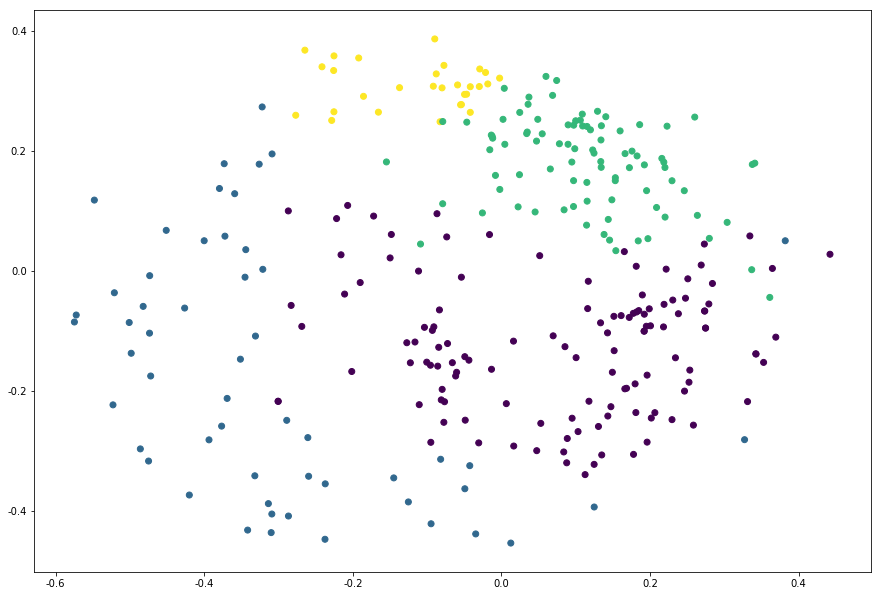

In [37]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=clustering.labels_)
plt.show()

# 繪製盒鬚圖

## 一. 抓出標準差

In [71]:
SD = np.std(NAV, axis=1, ddof=1)
SD = pd.DataFrame(data={'SD':SD, 'label':clustering.labels_})

In [79]:
SD

array([7.52061725e-01, 4.63062498e-02, 3.28729739e-02, 8.74138537e-01,
       4.19887198e+02, 2.77384737e-01, 3.35083613e-01, 5.02641245e-02,
       5.55923901e-02, 4.90037161e+00, 4.71562871e-02, 7.89083874e-01,
       2.19973947e-02, 3.44470310e-02, 9.17484962e-02, 6.47250188e-04,
       1.50177760e-02, 5.36299353e-01, 3.67543926e-01, 1.38907368e-01,
       1.38911636e-01, 9.87847991e+00, 9.56731921e-02, 2.79397998e-02,
       4.05912847e+00, 1.37883493e-01, 1.11528936e+00, 2.44800475e-01,
       5.12778990e-01, 4.42417180e+01, 6.46272376e-02, 1.99937698e-02,
       1.06978000e-01, 1.00870696e-01, 1.94981503e-01, 8.41488423e-02,
       2.07860359e-01, 2.80949829e-02, 2.48710246e+00, 1.89546067e-01,
       1.20055483e+01, 2.55514671e-01, 9.40291562e-01, 1.03199124e-02,
       3.11812166e-01, 1.22232203e-02, 9.64979674e-02, 2.04137054e-01,
       2.38821216e-02, 6.45322176e+01, 9.93098716e-03, 1.74837022e-01,
       9.01656140e-01, 3.29929924e-02, 2.20951437e+00, 2.70470239e-01,
      

In [40]:
mean = np.mean(rate, axis=1)
mean = pd.DataFrame(data={'mean':mean, 'label':clustering.labels_})

In [41]:
mean

,mean,label
0,3.256942e-03,0
1,2.158896e-04,2
2,8.603967e-04,3
3,4.700143e-03,0
4,2.240646e-04,2
5,3.734654e-03,0
6,4.490983e-03,0
7,2.527294e-04,0
8,2.680325e-04,2
9,1.435838e-04,2


## 二.繪圖

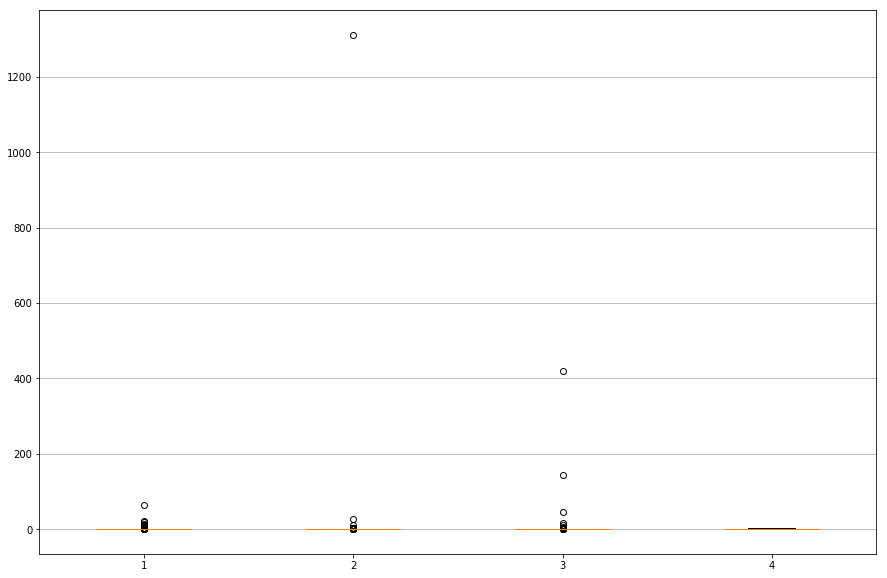

In [42]:
plt.figure(figsize=(15, 10))
plt.grid(axis='y')
plt.boxplot([SD[SD['label'] == 0]['SD'].values,
             SD[SD['label'] == 1]['SD'].values,
             SD[SD['label'] == 2]['SD'].values,
             SD[SD['label'] == 3]['SD'].values])
plt.show()

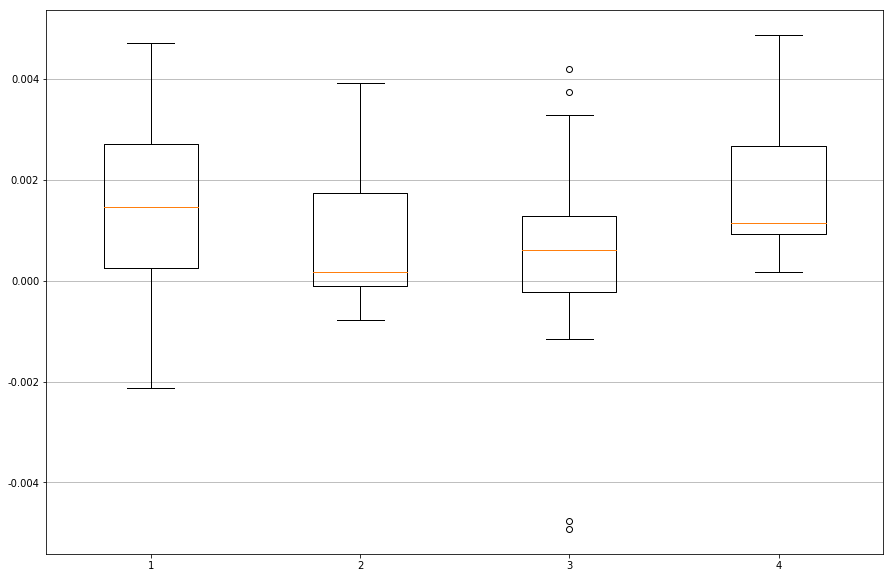

In [43]:
plt.figure(figsize=(15, 10))
plt.grid(axis='y')
plt.boxplot([mean[mean['label'] == 0]['mean'].values,
             mean[mean['label'] == 1]['mean'].values,
             mean[mean['label'] == 2]['mean'].values,
             mean[mean['label'] == 3]['mean'].values])
plt.show()

# 5.抓出四支基金

In [44]:
camp = pd.DataFrame(data=clustering.labels_, index=names,columns=['label'])
name_choose = []
start = getTimeStamp(year+'-01-01')
end = getTimeStamp(year+'-12-31')
for i in range(4):
    name_choose.append(camp[camp['label'] == i].sample(n=1).index[0])

In [45]:
name_choose

['HHZ11 亨德森泛歐A2e',
 'ALZF6 聯博全高益B2 EUR',
 'UBA10 瑞聯歐洲股eurAC',
 'JAZ47 駿利美策略AUSD.a']

# 抓出四支基金各項數據

## 一. 淨值

In [46]:
NAV_choose = getNAV(name_choose, start, end)

In [47]:
NAV_choose

array([[ 14.68,  14.78,  14.71, ...,  16.68,  16.56,  16.47],
       [ 10.38,  10.49,  10.51, ...,  12.86,  12.82,  12.75],
       [229.19, 230.33, 230.75, ..., 267.26, 263.77, 262.83],
       [ 13.82,  13.88,  13.89, ...,  15.21,  15.21,  15.19]])

## 二.配息

In [48]:
interest_choose = 0
for name in name_choose:
    interest_choose += (pd.read_sql(sql='select interest from interest where date between ? and ? and id = ?'
                                ,con = engine, params=[start,end,name])['interest'].sum())

In [49]:
interest_choose

0

## 三. 漲跌幅

In [50]:
temp = np.zeros((len(name_choose), len(NAV_choose[0])-1))
for j in range (len(name_choose)):
    for i in range (len(NAV_choose[0])-1):
        temp[j][i] = (NAV_choose[j][i+1] - NAV_choose[j][i]) / NAV_choose[j][i]

rate_choose = []
for i in range(len(temp[0])):
    rate_choose.append((temp[0][i] + temp[1][i] + temp[2][i] + temp[3][i])/4)

In [51]:
rate_choose

[0.0066812161553137395,
 -7.140511115555145e-05,
 0.0032596786828879183,
 0.0039987170714270975,
 0.000461536247462718,
 -0.008529855545409483,
 0.0032655727555644535,
 0.0051645367701923335,
 -0.001726308799500318,
 -0.00025035436588899005,
 0.0038591703860683503,
 0.0009479715718723057,
 -0.006976439055176804,
 -0.016128918692355797,
 0.0001582526467160696,
 -0.0012308696605275134,
 0.0011076606378834703,
 -0.001970809698592425,
 -0.001049472424497286,
 0.0036446981052045387,
 0.00880012055823317,
 0.0008466833544416993,
 -0.01390099801489892,
 -0.014081156447539543,
 0.0,
 -0.001749190786096007,
 0.0027619452958082,
 0.0034682744684312945,
 0.03201285057476003,
 -0.004764011822127823,
 0.0004373637952231721,
 -0.0028677173470637303,
 0.0014326804043955324,
 0.010914782426289637,
 0.006889198227895056,
 0.0008290986038461194,
 0.005440978886362651,
 0.006821768566214137,
 0.0019407713727568397,
 -0.0006617069320235037,
 0.0051916541657322166,
 0.001299170004697606,
 0.000115246114707

## 四. 收益率

In [52]:
profit_choose = []
temp = NAV_choose[0][0] + NAV_choose[1][0] + NAV_choose[2][0] + NAV_choose[3][0]
for i in range(len(NAV_choose[0])):
    profit_choose.append((NAV_choose[0][i] + NAV_choose[1][i] + NAV_choose[2][i] + NAV_choose[3][i] - temp) / temp * 100)
profit_choose[-1] += interest_choose / temp * 100 

In [53]:
profit_choose

[0.0,
 0.52598201962175,
 0.6677360390942741,
 0.9512440780393223,
 1.3280113403215588,
 1.3914276121908737,
 0.2312828738762281,
 0.6341627186928744,
 1.2832469131197068,
 0.7125004662961261,
 1.033312194576058,
 1.5928675345991652,
 0.6975789905621683,
 -0.31708135934642667,
 -1.7308911851382052,
 -1.820420039541909,
 -1.6935874958033428,
 -1.7905770880740148,
 -2.241951729025997,
 -1.7681948744730887,
 -1.3056291267206328,
 -0.26112582534412226,
 -0.3879583690827099,
 -2.5888760398403394,
 -4.629387846458003,
 -4.629387846458003,
 -4.554780467788267,
 -4.28992427351065,
 -3.8758533218935307,
 -0.7125004662961261,
 -1.4809564665945352,
 -1.6600141754019428,
 -2.64110120490916,
 -1.604058641399639,
 -0.38049763121572044,
 0.30589025254597424,
 0.9661655537732801,
 1.193718058716024,
 2.2829857872943653,
 2.3389413212966907,
 2.2829857872943866,
 3.167083224530888,
 3.152161748796952,
 3.3797142537396954,
 2.8686537098519245,
 3.734099302421006,
 4.67788264259336,
 4.450330137650616,
 

# 繪製漲跌幅對比圖

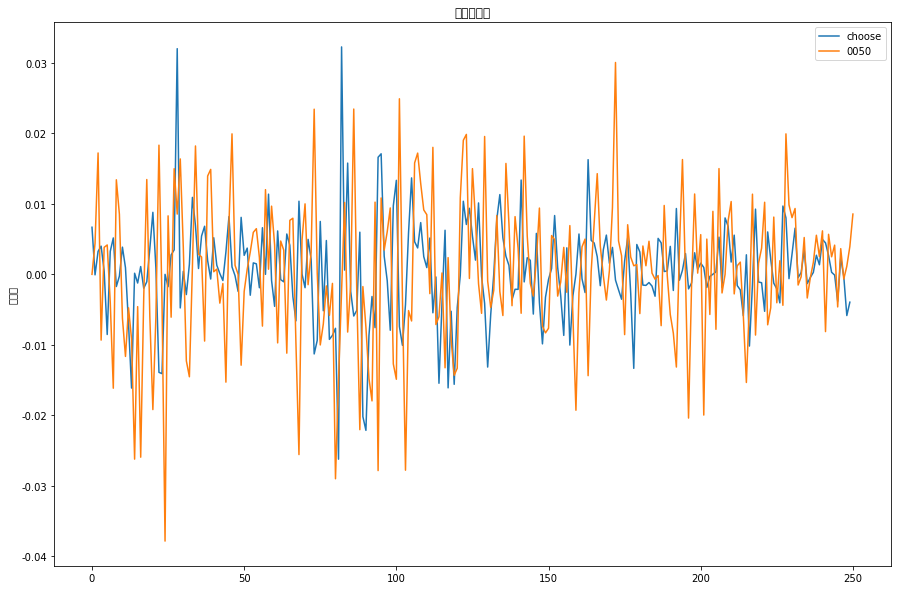

In [54]:
plt.figure(figsize=(15, 10))
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(rate_choose)
plt.plot(rate_0050)
plt.legend(['choose','0050'])
plt.show()

# 繪製收益率對比圖

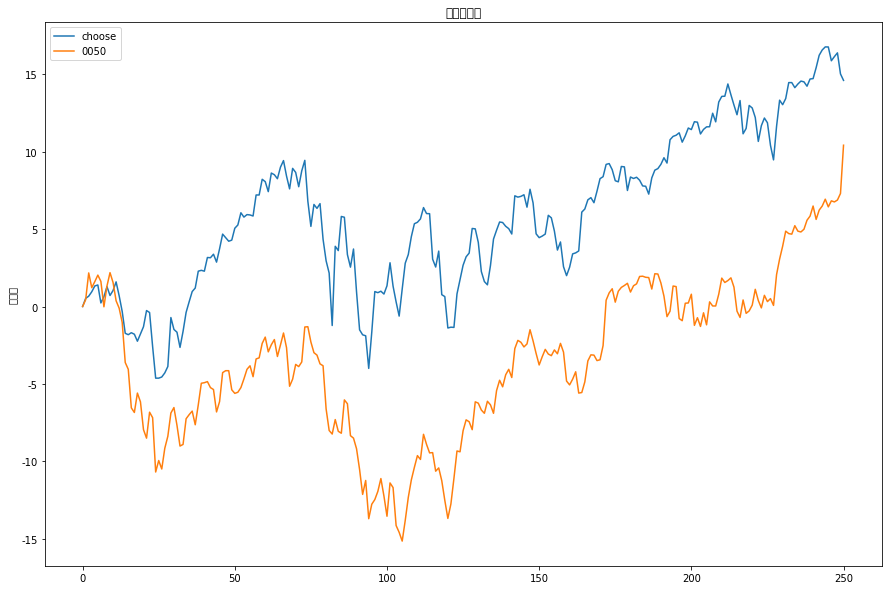

In [55]:
plt.figure(figsize=(15, 10))
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(profit_choose)
plt.plot(profit_0050)
plt.legend(['choose','0050'])
plt.show()

In [56]:
date = pd.read_sql(sql='select distinct datetime(date, "unixepoch") from price where date between ? and ? order by date asc',
                    con=engine, params=[start, end])

In [57]:
date['profit'] = profit_choose

In [58]:
date.rename(columns={'datetime(date, "unixepoch")':'date'}, inplace = True)

In [59]:
date.loc[1,'date']

'2010-01-05 00:00:00'

In [60]:
from datetime import datetime

In [61]:
for i,j in enumerate(date['date']):
     date.loc[i,'date'] = datetime.strptime(j, '%Y-%m-%d %H:%M:%S')

In [62]:
date

,date,profit
0,2010-01-04 00:00:00,0.000000
1,2010-01-05 00:00:00,0.525982
2,2010-01-06 00:00:00,0.667736
3,2010-01-07 00:00:00,0.951244
4,2010-01-08 00:00:00,1.328011
5,2010-01-11 00:00:00,1.391428
6,2010-01-12 00:00:00,0.231283
7,2010-01-13 00:00:00,0.634163
8,2010-01-14 00:00:00,1.283247
9,2010-01-15 00:00:00,0.712500


In [63]:
date.index = date.date

In [64]:
date = date.drop('date', axis=1)

In [65]:
from bokeh.models import HoverTool

In [66]:
p = figure(x_axis_type="datetime", plot_width=500, plot_height=500, title="Profit")
p.line(x='date',y= 'profit', line_width=2, source=date)
p.add_tools(HoverTool(tooltips=[("datetime", "@date{%F}"), ("profit", "@profit")], formatters={'date':'datetime',},
                     mode='vline'))
show(p)

# 夏普值 Sharpe Ratio

夏普值 = （報酬率 - 無風險利率）/ 標準差

In [235]:
#0050的夏普
NAV0050_SD = np.std(NAV_0050, ddof=0)

In [271]:
NAV0050_SD

2.8763242227310353

In [269]:
#假設無風險利率是1%
sharpe = (profit_0050[-1] - 0.01)/NAV0050_SD

In [270]:
sharpe

3.6202614506743136